![alt text](img/LM.png)
# Kurs: Deep Learning, Text Mining i XAI w Pythonie

## Autor: Piotr Ćwiakowski

### Lekcja 7. NLP: Uczenie nadzorowane i nienadzorowane

#### Spis treści:

1. Analiza sentymentu
2. Uczenie nienadzorowane
3. Uczenie nadzorowane

## Pakiety

Tradycyjnie rozpoczynamy od wczytania wszystkich potrzebnych pakietów.

In [112]:
import pickle
import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Text Mining
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer 
from sklearn import metrics

# Machine Learning - unsupervised
import gensim
import pyLDAvis
from gensim import corpora, models
from sklearn.cluster import KMeans, MiniBatchKMeans

# Machine Learning - supervised
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

from helpers import run_xgb
from helpers2 import plotROCs

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# 1 Analiza sentymentu

Celem analizy sentymentu jest ocena emocji, nastawienia, intencji autora na podstawie doboru słów w tekście. Detekcja sentymentu może być zarówno zadaniem uczenia nadzorowanego, jak  nienadzorowanego. W pierwszym przypadku naszym celem jest po prostu wytrenowanie modelu na zbiorze przygotowanym (oflagowanym) ex ante przez ludzi (eksperci czytają teksty i je ręcznie etykietują). Natomiast uczenie nienadzorowane polega na przyporządkowaniu na podstawie informacji zewnętrznej (odpowiedniego słownika) emocjonalnego ładunku do słów/sformułowań znajdujących się w tekście i ocenę ładunku emocjonalnego na podstawie składowych słów. 

Przeprowadzając analizę sentymentu należy pamiętać że:
* jedno słowo może przynależeć do wielu kategorii emocjonalnych,
* model może być nie dopasowany do kontekstu sytuacyjnego/tematycznego wypowiedzi,
* znaczenie słowa jest modyfikowane przez jego kontekst,
* ładunek emocjonalny jest różny w zależności od odbiorcy.

### Model Plutchika

Jest wiele psychologicznych teorii, które można zaaplikować do analizy sentymentu. Jedną z popularnych podejść jest propozycja Roberta Plutchika. Według niego wszystkie emocje wyrażane w słowach możemy podzielić na;

* złość,
* strach,
* smutek,
* zniechęcenie,
* zaskoczenie,
* oczekiwanie/zainteresowanie/
* przewidywanie,
* zaufanie,
* radość.

<img src="img/tm7.png" width="30%">
Źródło: Kwartler, Ted. "Text Mining in Practice with R." (2017).

Alternatywą do tego podejścia jest określenie zabarwienia słowa (pozytywne/negatywne) co nazywane jest polaryzacją. Metody zaimplementowane w Pythonie są o tyle interesujące, że nie skupiają się na punktowaniu pojedynczych słów, ale ocenią również jego kontekst. Sprawdzają się jednak przede wszystkim dla krótkich wypowiedzi (np. komentarze w mediach społecznościowych).

Przykładowa procedura:

1. Skanowanie tekstu i przypisywanie słowom znaczenia pozytywnego i negatywnego.
2. Kiedy słowa o zabarwieniu emocjonalnym są znalezione, algorytm tworzy klastry – dwa słowa poprzedzający każde słowa, i cztery następujące.
3. Następnie liczymy słowa w ramach klastra:
    - Neutralne słowa są liczone jako 0 
    - Pozytywne i negatywne słowa są liczone odpowiednio jako 1 i -1.
    - Pozostałe słowa, które nie są neutralne ani pozytywne, ani negatywne uznajemy za modyfikatory „valence shifters” (z domyślnymi wartościami 0.8 or -0.8). 
4. Sumujemy wszystkie punkty
5. Całkowitą sumę liczymy jako iloraz punktów z sentymentu i pierwiastka z liczby słów w klastrze. 

<img src="img/tm8.png" width="40%">
Źródło: Kwartler, Ted. "Text Mining in Practice with R." (2017).

### Dylematy metodologiczne w analizie sentymentu

* Problem arytmetyzacji działań – zazwyczaj oparte o odejmowanie i dodawanie.
* Problem oceny natężenia znaczenia każdego słowa względem innego – jak bardzo ‘wspaniały’ jest lepszy niż ‘dobry’?
* Tak zwane „subjectivity lexicons” zazwyczaj zawierają poniżej 10 tysięcy słów (szczęśliwie nie jest to duży problem zgodnie z rozkładem Zipfa - częstotliwość każdego słowa jest w przybliżeniu odwrotnie proporcjonalna do pozycji w tabeli częstości, ilustracja poniżej).

<img src="img/tm9.png" width="30%"> 

* Problem negacji i wzmocnienia słów e.g.:
    * “nie kocham”
    * “bardzo kocham”

Problem pojawiania się tego samego słowa w różnych kontekstach w tej samej wypowiedzi: „lubię Sony i nie lubię Panasonic”

Różnica w wyborze i zabarwieniu słów w zależności od audiencji, kontekstu, kraju:
* Ciao bella/bello!
* Grazie mille!
* lol/rotfl

W Pythonie analiza sentymentu jest dostępna w pakiecie `textblob`, zacznijmy od prostego przykładu dla pojedynczego zdania. Procedura zwraca ocenę polaryzacji (-1, 1) i subjektywności wypowiedzi (0, 1) czyli na ile jest oceną/opinią autora.

In [66]:
sentence = '''Sentiment analysis in R is very good'''
analysis = TextBlob(sentence).sentiment
print(analysis)

Sentiment(polarity=0.9099999999999999, subjectivity=0.7800000000000001)


In [67]:
1.8/np.sqrt(7)

0.680336051416609

Teraz przeprowadźmy analizę dla naszego korpusu, wczytajmy obiekty:

In [69]:
with open('minutesClean.p', 'rb') as fp:
    minutes = pickle.load(fp)
    
with open('minutesRaw.p', 'rb') as fp:
    minutesCopy = pickle.load(fp)
    
# Lista plików
lista_plikow = os.listdir('dataTM/minutes_nbp_en/')

Ponieważ w analizie sentymentu interpunkcja i stopwords mają znaczenie, posłużymy się tekstem nieoczyszczonym - musimy jednak trochę go poprawić:

In [70]:
minutesCopy[0]

" \n \n1\n/\n4\n \nMinutes of the Monetary Policy Council decision\n-\nmaking  \nmeeting held on \n17\n \nMarch 2020\n \nWhile\n \ndiscussing the current economic situation, the Council members\n \ndrew \nattention to the\n \nfact that \nthe \nglobal economic \nsituation\n \nhad\n \nsubstantially deteriorated\n \nas\n \na \nresult\n \nof the \nCOVID\n-\n19\n \npandemic and the measures taken by \nnumerous countries\n \nto \ncontain its\n \nspread\n.\n \nIn \nparticular, \neconomic\n \nactivity in the \nservice\n \nsector\n \nhad slowed down \nsignificantly\n, consumer sentiment had deteriorated, and many companies \nworldwide\n \nhad temporarily halted production.\n \nIn \nthese conditions, uncertainty about the \noutlook for global GDP growth\n \nhas risen \nsharply\n \nand \nfinancial market\n \nsentiment has \ndeteriorated significantly\n.\n \nThe \nprices of \nmany commodities\n, \nincluding \noil, \nhave \nplummeted\n, \nalong\n \nwith \na depreciation of \nsome \nemerging \nmarke

In [71]:
# Tokenizacja po białych znakach (spacjach, enterach, etc.)
for i, doc in enumerate(minutesCopy):
    # usuwanie podwójnych spacji oraz przede wszystkim '\n '
    minutesCopy[i] = re.sub(r'\s+', ' ', minutesCopy[i])
    # Usunięcie niektórych znaków interpunkcyjnych
    minutesCopy[i] = re.sub(r' (\.|,|;|:|%)', '\\1', minutesCopy[i])
    minutesCopy[i] = re.sub(r'(\.) (\d)', '\\1\\2', minutesCopy[i])
    minutesCopy[i] = re.sub(r'\d / \d ', '', minutesCopy[i])
    minutesCopy[i] = re.sub(r'^ | $', '', minutesCopy[i])
    # Usuwanie specyficznych stopwords
#     minutes[i] = [word for word in minutes[i].split() if word not in ['Monetary', 'Council', 'Policy', 'decision', 'members'] and word != '']
minutesCopy[0]

"Minutes of the Monetary Policy Council decision - making meeting held on 17 March 2020 While discussing the current economic situation, the Council members drew attention to the fact that the global economic situation had substantially deteriorated as a result of the COVID - 19 pandemic and the measures taken by numerous countries to contain its spread. In particular, economic activity in the service sector had slowed down significantly, consumer sentiment had deteriorated, and many companies worldwide had temporarily halted production. In these conditions, uncertainty about the outlook for global GDP growth has risen sharply and financial market sentiment has deteriorated significantly. The prices of many commodities, including oil, have plummeted, along with a depreciation of some emerging market economies' currencies. It was pointed out that although according to the official data in China the spread of the coronavirus epidemic had slowed, and following this, activity in the Chines

In [72]:
# Słownik sentymentu - zapisujemy w formie słownika
minutesSent = {plik: TextBlob(tekst).sentiment for plik, tekst in zip(lista_plikow, minutesCopy)}
minutesSent

{'mi_17iii2020en.pdf': Sentiment(polarity=0.07744856934001666, subjectivity=0.3940935672514618),
 'mi_i2010en.pdf': Sentiment(polarity=0.06908501110882063, subjectivity=0.40235907831145945),
 'mi_i2011en.pdf': Sentiment(polarity=0.04709981167608287, subjectivity=0.3725736222346392),
 'mi_i2012en.pdf': Sentiment(polarity=0.051805365686944646, subjectivity=0.3744328149920257),
 'mi_i2013en.pdf': Sentiment(polarity=0.01838403207530724, subjectivity=0.32988509253609927),
 'mi_i2014en.pdf': Sentiment(polarity=0.019712517529418938, subjectivity=0.35295759404914334),
 'mi_i2015en.pdf': Sentiment(polarity=0.03537682014954744, subjectivity=0.32686424983216433),
 'mi_i2016en.pdf': Sentiment(polarity=0.04118126756284654, subjectivity=0.37259792473608255),
 'mi_i2017en.pdf': Sentiment(polarity=0.09080665599573161, subjectivity=0.4059590502867813),
 'mi_i2018en.pdf': Sentiment(polarity=0.07152090111406882, subjectivity=0.4044544020506754),
 'mi_i2019en.pdf': Sentiment(polarity=0.06780574795574797, 

In [73]:
# Słownik tradycyjnie zamieniamy na DataFrame:
dfSent = pd.DataFrame(minutesSent).transpose()
dfSent.rename({0: 'polarity', 1: 'subjectivity'}, inplace=True, axis = 1)
dfSent.head()

,polarity,subjectivity
mi_17iii2020en.pdf,0.077449,0.394094
mi_i2010en.pdf,0.069085,0.402359
mi_i2011en.pdf,0.047100,0.372574
mi_i2012en.pdf,0.051805,0.374433
mi_i2013en.pdf,0.018384,0.329885


<AxesSubplot:title={'center':'Sentiment Polarity Distribution'}, ylabel='Frequency'>

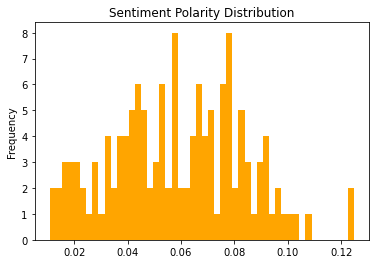

In [63]:
# I na przykład rysujemy histogram:
dfSent['polarity'].plot(
    kind='hist',
    bins=50,
    color='orange',
    ylabel ='count',
    title='Sentiment Polarity Distribution')

Spróbujmy zaprezentować zmianę polaryzacji raportów NBP w czasie:

In [75]:
daty = dfSent.index.str.replace('mi_\\d*', '', regex=True).str.replace('en.pdf', '', regex=False)
print(daty)

miesiac = [re.findall((r'[a-z]+'), s)[0] for s in daty]
rok = [re.findall((r'\d+'), s)[0] for s in daty]
print(miesiac, rok)

def roman_to_int(s):
    rom_val = {'i': 1, 'v': 5, 'x': 10, 'l': 50, 'c': 100, 'd': 500, 'm': 1000}
    int_val = 0
    for i in range(len(s)):
        if i > 0 and rom_val[s[i]] > rom_val[s[i - 1]]:
            int_val += rom_val[s[i]] - 2 * rom_val[s[i - 1]]
        else:
            int_val += rom_val[s[i]]
    return int_val

miesiac = [roman_to_int(m) for m in miesiac]
dzien = ['17'] + ['01' for x in range(len(miesiac)-1)]


daty = pd.DatetimeIndex([d+'-'+str(m)+'-'+r for d, m, r in zip(dzien, miesiac, rok)], dayfirst=True)
daty

Index(['iii2020', 'i2010', 'i2011', 'i2012', 'i2013', 'i2014', 'i2015',
       'i2016', 'i2017', 'i2018',
       ...
       'xii2012', 'xii2013', 'xii2014', 'xii2015', 'xii2016', 'xii2017',
       'xii2018', 'xii2019', 'xii2020', 'xii2021'],
      dtype='object', length=136)
['iii', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'ii', 'ii', 'ii', 'ii', 'ii', 'ii', 'ii', 'ii', 'ii', 'ii', 'ii', 'ii', 'iii', 'iii', 'iii', 'iii', 'iii', 'iii', 'iii', 'iii', 'iii', 'iii', 'iii', 'iii', 'iii', 'iv', 'iv', 'iv', 'iv', 'iv', 'iv', 'iv', 'iv', 'iv', 'iv', 'iv', 'iv', 'iv', 'ix', 'ix', 'ix', 'ix', 'ix', 'ix', 'ix', 'ix', 'ix', 'ix', 'ix', 'ix', 'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v', 'vi', 'vi', 'vi', 'vi', 'vi', 'vi', 'vi', 'vi', 'vi', 'vi', 'vi', 'vi', 'vii', 'vii', 'vii', 'vii', 'vii', 'vii', 'vii', 'vii', 'vii', 'vii', 'viii', 'viii', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'xi', 'xi', 'xi', 'xi', 'xi', 'xi', 'xi', 'xi', 'xi', 'xi', 

DatetimeIndex(['2020-03-17', '2010-01-01', '2011-01-01', '2012-01-01',
               '2013-01-01', '2014-01-01', '2015-01-01', '2016-01-01',
               '2017-01-01', '2018-01-01',
               ...
               '2012-12-01', '2013-12-01', '2014-12-01', '2015-12-01',
               '2016-12-01', '2017-12-01', '2018-12-01', '2019-12-01',
               '2020-12-01', '2021-12-01'],
              dtype='datetime64[ns]', length=136, freq=None)

In [78]:
dfSent.set_index(daty, inplace=True)
dfSent.sort_index()

,polarity,subjectivity
2010-01-01,0.069085,0.402359
2010-02-01,0.049549,0.398291
2010-03-01,0.057773,0.379381
2010-04-01,0.068412,0.360001
2010-05-01,0.078607,0.340385
...,...,...
2021-12-01,0.066713,0.363749
2022-01-01,0.081998,0.323155
2022-02-01,0.091725,0.359557
2022-03-01,0.063953,0.301805


<AxesSubplot:>

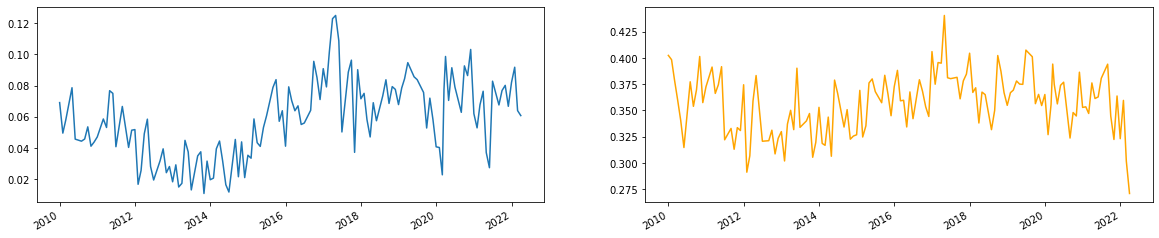

In [84]:
fig, axes = plt.subplots(ncols=2, figsize = (20, 4))
dfSent['polarity'].plot(ax = axes[0])
dfSent['subjectivity'].plot(ax = axes[1], color = 'orange')

`Textblob` zawiera również wytrenowane na zbiorze recenzji modele, które potrafią prognozować sentyment dokumentow. Jest to co prawda funkcja należąca do uczenia nadzorowanego, ale jest na tyle zautomatyzowana, że zamieścimy ją tutaj:

In [85]:
# Przykład dla pojedynczego artykułu:
TextBlob(minutesCopy[0], analyzer=NaiveBayesAnalyzer()).sentiment

Sentiment(classification='pos', p_pos=1.0, p_neg=9.806204467208635e-35)

Dla całego korpusu procedura trwa bardzo długo - dlatego kod wykonujący obliczenia jest zakomentowany - a my wczytamy gotowy obiekt.

In [86]:
# minutesClass = pd.DataFrame({plik: TextBlob(tekst, analyzer=NaiveBayesAnalyzer()).sentiment for plik, tekst in zip(lista_plikow, minutesCopy)})
# minutesClass.drop(labels = 0, axis=0, inplace=True)
# minutesClass.rename({2: 'negative', 1: 'positive'}, inplace=True)
# minutesClass = minutesClass.transpose()
# with open('sentPredUnsuper.p', 'wb') as fp:
#     pickle.dump(minutesClass, fp)
with open('sentPredUnsuper.p', 'rb') as fp:
    minutesClass = pickle.load(fp)
    
minutesClass.head()

,positive,negative
mi_17iii2020en.pdf,1.0,0.0
mi_i2010en.pdf,1.0,0.0
mi_i2011en.pdf,1.0,0.0
mi_i2012en.pdf,1.0,0.0
mi_i2013en.pdf,1.0,0.0


Wygląda na to, że model zadziałał "słabo" (lub może "podejrzanie" jest lepszym słowem) - wszystkie artykułu zostały zaklasyfikowane jako pozytywne z p-stwem 1. Dlaczego tak się mogło stać?

In [87]:
minutesClass.sum()

positive    136.0
negative      0.0
dtype: object

### Więcej informacji:
* https://neptune.ai/blog/sentiment-analysis-python-textblob-vs-vader-vs-flair
* https://planspace.org/20150607-textblob_sentiment/
* https://www.cs.uic.edu/~liub/FBS/SentimentAnalysis-and-OpinionMining.pdf
* https://towardsdatascience.com/my-absolute-go-to-for-sentiment-analysis-textblob-3ac3a11d524

# 2 Uczenie nienadzorowane

W uczeniu nienadzorowanym zdecydowaliśmy się na zaprezentowanie przykładu klasycznej segmentacji danych (KMeans) oraz analizy tematów. W dalszej części (rozdziale 3) pojawia się też wątek redukcji wymiarów - kasowane są zmienne z bardzo małą liczbą wartości niezerowych. Najpierw przygotujmy dane - potrzebujemy macierzy DTM.

In [95]:
# Przygotowanie danych
df = pd.DataFrame({plik :' '.join(minute) for plik, minute in zip(lista_plikow, minutes)},index=[0])

In [96]:
# Transformacja tabeli
vectorizer = CountVectorizer()
doc_vec = vectorizer.fit_transform(df.iloc[0])

dfCount = pd.DataFrame(doc_vec.toarray().transpose(), index=vectorizer.get_feature_names_out())
dfCount.columns = df.columns
dfCount = dfCount.transpose()
dfCount.head()

,abandon,abate,ability,able,abolition,abroad,abrogation,absence,absorb,absorber,...,yield,young,yuan,yy,zero,zl,zloty,zlotydenominate,ﬁlabour,ﬁundervaluationﬂ
mi_17iii2020en.pdf,0,0,0,0,0,0,0,0,0,0,...,2,0,0,1,1,0,0,0,0,0
mi_i2010en.pdf,0,0,0,1,0,6,0,0,0,0,...,0,0,0,0,0,0,6,0,0,0
mi_i2011en.pdf,0,0,1,0,0,3,0,1,0,0,...,0,0,0,0,0,0,2,0,0,0
mi_i2012en.pdf,0,0,0,0,0,4,0,0,0,0,...,0,0,0,0,0,0,3,0,0,0
mi_i2013en.pdf,0,1,0,0,0,2,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


Policzenie macierzy DTM:

In [97]:
dfTf = dfCount.apply(lambda x: x/x.sum(), axis=1)
dfTf.head()

,abandon,abate,ability,able,abolition,abroad,abrogation,absence,absorb,absorber,...,yield,young,yuan,yy,zero,zl,zloty,zlotydenominate,ﬁlabour,ﬁundervaluationﬂ
mi_17iii2020en.pdf,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.002,0.0,0.0,0.001,0.001000,0.0,0.000000,0.0,0.0,0.0
mi_i2010en.pdf,0.0,0.000000,0.000000,0.000876,0.0,0.005259,0.0,0.000000,0.0,0.0,...,0.000,0.0,0.0,0.000,0.000000,0.0,0.005259,0.0,0.0,0.0
mi_i2011en.pdf,0.0,0.000000,0.000948,0.000000,0.0,0.002844,0.0,0.000948,0.0,0.0,...,0.000,0.0,0.0,0.000,0.000000,0.0,0.001896,0.0,0.0,0.0
mi_i2012en.pdf,0.0,0.000000,0.000000,0.000000,0.0,0.004745,0.0,0.000000,0.0,0.0,...,0.000,0.0,0.0,0.000,0.000000,0.0,0.003559,0.0,0.0,0.0
mi_i2013en.pdf,0.0,0.001222,0.000000,0.000000,0.0,0.002445,0.0,0.000000,0.0,0.0,...,0.000,0.0,0.0,0.000,0.001222,0.0,0.000000,0.0,0.0,0.0


Teraz macierz TfIdf:

In [98]:
vectorizer = TfidfVectorizer()
doc_vec = vectorizer.fit_transform(df.iloc[0])

dfTfIdf = pd.DataFrame(doc_vec.toarray().transpose(), index=vectorizer.get_feature_names_out())
dfTfIdf.columns = df.columns
dfTfIdf = dfTfIdf.transpose()
dfTfIdf.head()

,abandon,abate,ability,able,abolition,abroad,abrogation,absence,absorb,absorber,...,yield,young,yuan,yy,zero,zl,zloty,zlotydenominate,ﬁlabour,ﬁundervaluationﬂ
mi_17iii2020en.pdf,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.03973,0.0,0.0,0.024269,0.013872,0.0,0.000000,0.0,0.0,0.0
mi_i2010en.pdf,0.0,0.000000,0.000000,0.035708,0.0,0.057546,0.0,0.000000,0.0,0.0,...,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.075213,0.0,0.0,0.0
mi_i2011en.pdf,0.0,0.000000,0.030667,0.000000,0.0,0.030243,0.0,0.020841,0.0,0.0,...,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.026352,0.0,0.0,0.0
mi_i2012en.pdf,0.0,0.000000,0.000000,0.000000,0.0,0.052569,0.0,0.000000,0.0,0.0,...,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.051531,0.0,0.0,0.0
mi_i2013en.pdf,0.0,0.043316,0.000000,0.000000,0.0,0.025239,0.0,0.000000,0.0,0.0,...,0.00000,0.0,0.0,0.000000,0.018219,0.0,0.000000,0.0,0.0,0.0


In [99]:
# lista zmiennych:
features = dfCount.columns.tolist()

Do zbiory dołożymy daty - w celu opisu wyników:

In [100]:
dfCount['miesiac'] = miesiac
dfCount['rok'] = rok
dfCount['daty'] = daty

dfTf['miesiac'] = miesiac
dfTf['rok'] = rok
dfTf['daty'] = daty

dfTfIdf['miesiac'] = miesiac
dfTfIdf['rok'] = rok
dfTfIdf['daty'] = daty

## 2.1 Segmentacja danych

In [108]:
km = KMeans(n_clusters=5,init="k-means++", max_iter=100, n_init=1, verbose=True)

In [109]:
km.fit(dfCount[features])

Initialization complete
Iteration 0, inertia 334869.0
Iteration 1, inertia 197758.9676035762
Iteration 2, inertia 194798.3806212806
Iteration 3, inertia 193458.36075124893
Iteration 4, inertia 192031.2645330725
Iteration 5, inertia 191375.96271538915
Converged at iteration 5: strict convergence.


KMeans(max_iter=100, n_clusters=5, n_init=1, verbose=True)

In [110]:
dfTfIdf['klastry'] = km.labels_

for klaster in dfTfIdf['klastry'].unique():
    display(dfTfIdf.query('klastry == @klaster')['rok'].value_counts().to_frame().sort_index())

,rok
2020,9
2021,8


,rok
2010,6
2011,10
2012,11
2013,8
2014,9


,rok
2014,1
2015,10
2016,11
2017,4
2018,11
2019,7
2020,1


,rok
2013,3
2014,1
2017,7
2019,4
2020,2
2021,3
2022,4


,rok
2010,5
2015,1


## 2.2 Topic analysis

Topic modeling is to technika która polega jednoczesnym klasyfikowaniu dokumentów według tematów i opisywaniu tych tematów przez słowa kluczowe. Jest to algorytm uczenia nienadzorowanego, dlatego a priori nie znamy prawidłowego rozwiązania (choć możemy się go domyślać). Najczęściej wymianiane modele:

* Explicit semantic Analysis
* Latent Semantic Analysis/Latent Semantic Index
* __Latent Dirichlet Allocation__
* Hierarchical Dirichlet Process
* Non-negative Matrix Factorization

### Latent Dirichlet Allocation

LDA to najpopularniejszym algorytmem w analizach tematycznych. W ogólności, szuka klastrów dla w bazie danych dokumentów o podobnym rozkładzie występowania słów.  W tym podejściu zakładamy, że każdy artykuł jest kompilacją kilku tematów – może być opisany przez ich rozkład, gdzie prawdopodobieństwa możemy interpretować jako udział tematu w artykule. Z drugiej strony, tematy mają swoje słowniki – czyli wektor prawdopodobieństwa, z jakim każde słów może być użyte to wygłoszenia komunikatu (zdania, paragrafu) na dany temat.  Na przykład „IT” lub „CPU” ma większe prawdopodobieństwo pojawienia się w artykule technicznym niż „pies”. Innymi słowy, zakładamy, że kiedy człowiek decyduje się coś napisać i wybiera cel swojego artykułu, jest on zawsze mieszaniną kilku ogólnych tematów. Każdy temat ma swój słownik, czyli wybór tematów determinuje prawdopodobieństwo z jakim dane słowo zostanie użyte.

<img src="img/tm10.png" width="30%">

<img src="img/tm11.png" width="40%">

#### Przykład
Prosty przykład, rozpatrzmy następujące zdania:

* I like to eat broccoli and bananas.
* I ate a banana and spinach smoothie for breakfast.
* Chinchillas and kittens are cute.
* My sister adopted a kitten yesterday.
* Look at this cute hamster munching on a piece of broccoli.

Interpretacja (według LDA) byłaby następująca:

* Zdanie 1 i 2 w 100% składa się z Tematu A
* Zdanie 3 i 4 w 100% z tematu B
* Zdanie 5: 60% Temat,40% Temat B
* Temat A: 30% Broccoli, 15% banany, 10% śniadanie…
* Temat B: 20% chinchillas, 20% kittenss, 20% cut, 15% 

Otagujmy nowe dokumenty:
* Banana and spinach smoothie is a good combination for a healthy breakfast.
* Kittens look cute as they munch on a bowl of milk, bananas, and chocolates.

Pierwsze zdanie to w 100% temat A i drugie zdanie to w 40% temat B oraz 60% temat A.

#### Opis modelu

Ideą LDA jest szukanie dokumentów o podobnych rozkładzie słów. Założenie modelu wypisano poniżej:

* Liczba słów w artykule wybierana jest według rozkładu Poisson.

* Rozkład tematów w dokumentach i słów w tematach jest rozkładem Dirichleta (złożenie pewnych rozkładów ciągłych i dyskretnych. Definiujemy następujące parametry:
    - α — Parametr rozkładu Dirichleta odnoszący się do ogólnej postaci rozkładu tematów
    - θ — Losowa macierz gdzie θ(i, j) reprezentuje prawdopodobieństwo że i-ty dokumentu zawiera j-ty temat
    - η — parametr rozkładu Dirichleta odnoszący się do ogólnej postaci rozkłady prawdopodobieństwa słów w tematach
    - β —Losowa macierz gdzie β(i, j) reprezentuje prawdopodobieństwo że i-ty temat będzie zawierał j-te słowo.

<img src="img/tm12.png" width="30%">

#### Przykład (2)

Wynikiem algorytmu (w uproszczeniu) są dwie tabele (beta i gamma). Przeanalizujmy je na przykładzie – załóżmy że naszymi obserwacjami są rozdziały 4 książki:  Duma i uprzedzenie, 20 tys. mil podmorskiej żeglugi, Wojna światów i Wielkie Nadzieje. Dla uproszczenia, szukamy w zbiorze 4 tematów. Poniżej wizualizacja wyników.


<img src="img/tm13.png" width="40%">


<img src="img/tm14.png" width="40%">

Sprawdźmy model w praktyce:

In [128]:
# Przygotowanie danych:
dictionary = corpora.Dictionary(minutes)
corpus = [dictionary.doc2bow(text) for text in minutes]
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=3, id2word = dictionary, passes=20, random_state=2022)
ldamodel.print_topics()

[(0,
  '0.024*"council" + 0.022*"member" + 0.019*"economic" + 0.019*"inflation" + 0.017*"rate" + 0.015*"price" + 0.014*"would" + 0.011*"also" + 0.011*"growth" + 0.011*"point"'),
 (1,
  '0.035*"council" + 0.032*"member" + 0.023*"growth" + 0.021*"rate" + 0.018*"inflation" + 0.015*"economic" + 0.013*"point" + 0.011*"interest" + 0.010*"also" + 0.010*"policy"'),
 (2,
  '0.036*"growth" + 0.031*"council" + 0.027*"member" + 0.019*"rate" + 0.018*"price" + 0.017*"economic" + 0.012*"inflation" + 0.012*"interest" + 0.010*"economy" + 0.010*"remain"')]

In [129]:
# Przygotowanie danych do prezentacji interaktywnej za pośrednictwem LDAvis
doc_topic = [[x[1] for x in ldamodel.get_document_topics(item, minimum_probability=0.0)] for item in corpus]
doc_topic = np.array(doc_topic)

minutes_all = sum(minutes, [])
term_counts = [minutes_all.count(w) for w in list(dictionary.values())]

vocab = list(dictionary.values())

doc_lengths = [len(x) for x in minutes]

In [130]:
pyLDAvis.enable_notebook()

In [131]:
LDAvis_prepared = pyLDAvis.prepare(**{'topic_term_dists': ldamodel.get_topics(), 
                                      'doc_topic_dists': doc_topic, 
                                      'doc_lengths': doc_lengths , 
                                      'vocab': vocab, 
                                      'term_frequency': term_counts})

C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [ ]:
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(4) +'.html')    
LDAvis_prepared

### Więcej informacji:
* https://github.com/kapadias/mediumposts/blob/master/natural_language_processing/topic_modeling/notebooks/Introduction%20to%20Topic%20Modeling.ipynb
* https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

# 3 Uczenie nadzorowane

Uczenie nadzorowane to po prostu wykorzystanie DTM i technik feature engineering w modelach poznanych na poprzednich zajęciach i poprzednim kursie [Warsztaty Machine Learning w Pythonie](https://labmasters.pl/kursy-otwarte/python/p-3/). W literaturze i artykułach publicystycznych w Internecie często mówi się dodatkowo o modelu `NaiveBayes`, ale w praktyce się go nie wykorzystuje ponieważ nie dominuje ani w zakresie skuteczności, ani szybkości obliczeń.

In [302]:
lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')

spam = pd.read_csv('dataTM/spam.csv')

# Czyszczenie danych
spam['text'] = spam['text'].apply(lambda x: x.lower())
spam['text'] = spam['text'].apply(lambda x: ' '.join([x for x in x.split() if len(x) > 1]))
spam['text'] = spam['text'].apply(lambda x: ' '.join([x for x in x.split() if x.isalpha()]))
spam['text'] = spam['text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(x) for x in x.split() if len(x) > 1]))
spam['text'] = spam['text'].apply(lambda x: ' '.join([x for x in x.split() if x not in stop_words]))

# Feature engineering
spam['wordCount'] = spam['text'].apply(lambda x: len(x.split()))
spam['sentiment'] = spam['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

spam.head()

,label,text,wordCount,sentiment
0,ham,go jurong available bugis great world la cine ...,10,0.6
1,ham,ok joking wif,3,0.5
2,spam,free entry wkly comp win fa cup final tkts may...,16,0.4
3,ham,dun say early already,4,0.1
4,ham,nah think go life around though,6,0.0


In [326]:
features = list(vectorizer.get_feature_names_out())
features2 = ['wordCount', 'sentiment']
target = 'label'

In [328]:
df = pd.concat([spam[[target]], spam[['wordCount', 'sentiment']], dtm], axis=1)
df['label'] = df['label'].apply(lambda x: 1 if x == 'ham' else 0) 
df.head()

,label,wordCount,sentiment,aa,aah,aaniye,aaooooright,abdomen,abi,ability,...,zhong,zindgi,zoe,zoom,zouk,zyada,åð,åòharry,åôrents,ìï
0,1,10,0.6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,3,0.5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,16,0.4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,4,0.1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,6,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [353]:
# Przygotujmy wrapper
def CVTestRFClass(features, target, nFolds = 5, randomState=2020, debug=False, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # listy do przechowywania wyników:
    testResults = []
    trainResults = []
    predictions = []
    indices = []

    # Pętla walidująca model na kolejnych foldach
    for train, test in kf.split(df.index.values):
        # Przygotowanie estymatora
        clf = RandomForestClassifier(*args, **kwargs, random_state=randomState, n_jobs=-1)
        if debug:
            print(clf)
        # Trenowanie modelu
        clf.fit(df.iloc[train][features], df.iloc[train][target])

        # Przygotowanie prognoz dla zbioru treningowego i testowego
        # UWAGA Sklearn zwracał będzie dwie kolumny prawdopodobieństw dla obydwu klas
        predsTrain = clf.predict_proba(df.iloc[train][features])[:,1]
        preds = clf.predict_proba(df.iloc[test][features])[:,1]
        
        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(preds.tolist().copy())
        
        # Razem z indeksami w oryginalnym data frame
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Policzenie dopasowania za pomocą metryki ROC-AUC
        trainScore = roc_auc_score(df[target].iloc[train], predsTrain)
        testScore = roc_auc_score(df[target].iloc[test], preds)
        
        # Zapisanie wyników do listy 
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return np.round(trainResults,5), np.round(testResults,5), predictions, indices

In [354]:
trainResults, testResults, predictions, indices = CVTestRFClass(features=features, target=target, max_depth=12)
print(np.mean(trainResults), np.mean(testResults))

0.981628 0.9687300000000001


In [362]:
trainResults, testResults, predictions, indices = CVTestRFClass(features=features+features2, target=target, max_depth=12)
print(np.mean(trainResults), np.mean(testResults))

0.982918 0.9717560000000001


In [364]:
# Zredukujmy liczbę kolumn
features_short = df.columns[df.apply(lambda x: x.loc[x>0].sum())>5].tolist()
features_short.remove('label')
print(len(features_short))

1058


In [366]:
# Przygotujmy prosty wrapper
def CVTestXGB(features, target, nFolds = 5, randomState=2020, debug=False, *args, **kwargs):
    
    # Przygotujmy walidację krzyżową
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # Zapisanie wyników ze zbioru treningowego i testowego
    testResults = []
    trainResults = []
    
    # Przechowajmy również predykcje dla poszczególnych foldów
    predictions = []
    
    # Razem z informacją o tym, jaki był ich indeks w oryginalnym zbiorze danych
    indices = []
    
    # Przygotujmy listę historii
    hists = []
    fold = 1
    for train, test in kf.split(df.index.values):
        # Przygotowanie estymatora
        score, trainPred, testPred, train_history, impFig, imp = run_xgb(df.iloc[train], df.iloc[test],
                                                                         features, target, debug=debug, *args, **kwargs)

        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(testPred.tolist().copy())
        
        # Razem z indeksami w oryginalnym data frame
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        trainScore = roc_auc_score(df[target].iloc[train], trainPred)
        testScore = roc_auc_score(df[target].iloc[test], testPred)
        
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        hists.append(train_history.add_suffix('_'+str(fold)))
        fold+=1
        
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions, indices, pd.concat(hists, axis=1)

In [368]:
trainResults, testResults, predictions, indices, hists = CVTestXGB(features_short, target, max_depth=7, subsample = 0.8, num_boost_round=300, 
                                                                   colsample_bytree = 0.7, lambdaX=1, gamma=6, debug=False)
print(np.mean(trainResults), np.mean(testResults))

0.9700224330867607 0.9592755027821731
